# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Autoencoder in KERAS for timeseries anomaly detection via CNN



# Import modules
<hr style="border:2px solid black"> </hr>

In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import InputLayer
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

# Load the dataset
<hr style="border:2px solid black"> </hr>


- The Numenta Anomaly Benchmark(NAB) dataset provides artifical timeseries data containing labeled anomalous periods of behaviour. Data are ordered, timestamped, single-valued metrics.
- `art_daily_small_noise.csv` file used for training
- `the art_daily_jumpsup.csv` file used for testing. Essentially we'd like to know if the model capture this variation.
    


In [2]:
!ls "../DATASETS/Numenta_Anomaly_Benchmark(NAB)"

README.md             link_dataset.txt      realKnownCause
artificialNoAnomaly   realAWSCloudwatch     realTraffic
artificialWithAnomaly realAdExchange        realTweets


In [3]:
master_url_root = "../DATASETS/Numenta_Anomaly_Benchmark(NAB)/"

df_small_noise_url_suffix = "artificialNoAnomaly/artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = os.path.join(master_url_root, df_small_noise_url_suffix)
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)


df_daily_jumpsup_url_suffix = "artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = os.path.join(
    master_url_root, df_daily_jumpsup_url_suffix)
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [4]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [5]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


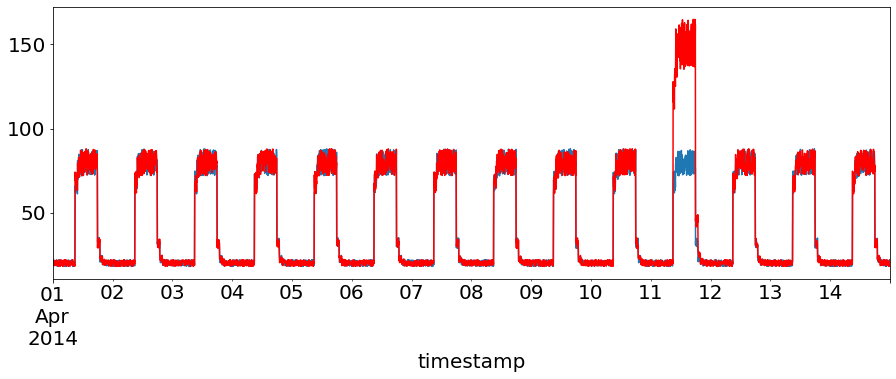

In [6]:
rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 20

fig, ax = plt.subplots()
# small normal noise
df_small_noise.plot(legend=False, ax=ax);
# anomaly coloured in red
df_daily_jumpsup.plot(legend=False,  ax=ax, c="r");


# Data preparation
<hr style="border:2px solid black"> </hr>


- Get data values from the training timeseries data file and normalize the value data. The normalisation is done via mean and standard deviation
    
- We have a value for every 5 mins for 14 days.
    - `24 * 60 / 5 = 288` timesteps per day
    - `288 * 14 = 4032` data points in total



In [7]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [8]:
# Checking the normalisation
df_training_value

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
...,...
2014-04-14 23:35:00,-0.791647
2014-04-14 23:40:00,-0.780255
2014-04-14 23:45:00,-0.833640



- The data as it is now is still not in the right format.
- We'd like to have to sample according to a single day. This defined a window where we'd like to capture if any anomaly are present.
- Create sequences combining TIME_STEPS contiguous data values from the training data.
- The shape of the output is `[,sequence_length, num_feature]`
    


In [9]:
TIME_STEPS = 288


def create_sequences(values, time_steps=TIME_STEPS):
    """Create sequence.

    Generated training sequences with a shift of 1
    Given: [1,2,3,4]reshape it as [[1,2],[2,3],[3,4]]
    with time_steps = 2
    """
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i: (i + time_steps)])
    return np.stack(output)
    # return np.array(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [10]:
x_train

array([[[-0.85882857],
        [-0.72899302],
        [-0.84814772],
        ...,
        [-0.86453747],
        [-0.81250829],
        [-0.79671155]],

       [[-0.72899302],
        [-0.84814772],
        [-0.72958579],
        ...,
        [-0.81250829],
        [-0.79671155],
        [-0.78767946]],

       [[-0.84814772],
        [-0.72958579],
        [-0.731173  ],
        ...,
        [-0.79671155],
        [-0.78767946],
        [-0.73706287]],

       ...,

       [[-0.8226548 ],
        [-0.86660975],
        [-0.82181363],
        ...,
        [-0.79164661],
        [-0.78025492],
        [-0.83364049]],

       [[-0.86660975],
        [-0.82181363],
        [-0.75595835],
        ...,
        [-0.78025492],
        [-0.83364049],
        [-0.73510213]],

       [[-0.82181363],
        [-0.75595835],
        [-0.74256753],
        ...,
        [-0.83364049],
        [-0.73510213],
        [-0.8460886 ]]])

# Modelling
<hr style="border:2px solid black"> </hr>


- We will build a convolutional reconstruction autoencoder model. 
- The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape. 
- In this case, sequence_length is 288 and num_features is 1.



In [25]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [26]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_9 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_7 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_10 (Conv1DT (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_11 (Conv1DT (None, 288, 1)           


- Please note that we are using x_train as both the input and the target since this is a reconstruction model.
- Reconstruction is what an autoencoder is suppose to learn. Learn to mimic the input. By doing so it is forced to learn a compressed representation of the input.
- An autoencoder is made of two element: encoder and decoder.



In [27]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    """
    mode = min training will stop when the quantity monitored has stopped decreasing
    """
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 2s 60ms/step - loss: 0.5746 - val_loss: 0.1295
Epoch 2/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0830 - val_loss: 0.0406
Epoch 3/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0566 - val_loss: 0.0364
Epoch 4/50
27/27 [==============================] - 1s 41ms/step - loss: 0.0484 - val_loss: 0.0314
Epoch 5/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0415 - val_loss: 0.0275
Epoch 6/50
27/27 [==============================] - 1s 35ms/step - loss: 0.0360 - val_loss: 0.0247
Epoch 7/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0313 - val_loss: 0.0229
Epoch 8/50
27/27 [==============================] - 1s 39ms/step - loss: 0.0281 - val_loss: 0.0216
Epoch 9/50
27/27 [==============================] - 1s 39ms/step - loss: 0.0256 - val_loss: 0.0201
Epoch 10/50
27/27 [==============================] - 1s 43ms/step - loss: 0.0238 - val_loss: 0.0210
Epoch 11/

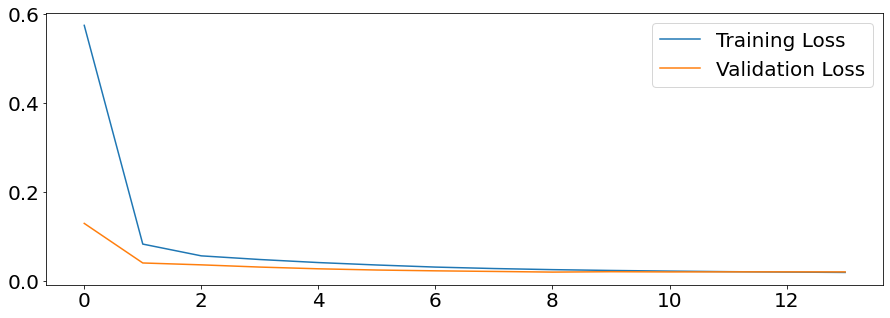

In [28]:
rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 20

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


# Inference
<hr style="border:2px solid black"> </hr>

In [30]:
x_train_pred = model.predict(x_train)

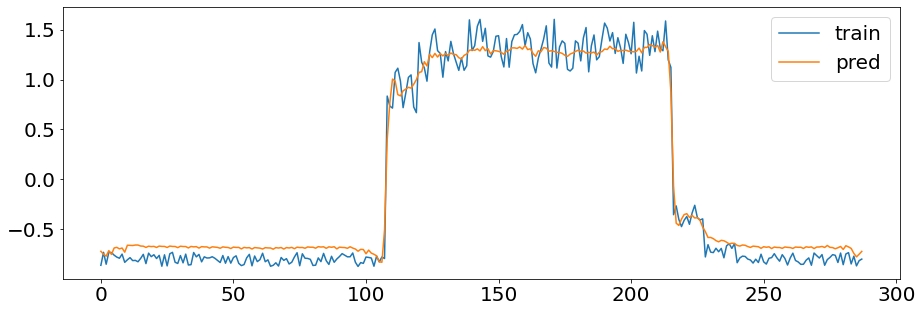

In [39]:
rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 20

# Let's plot the first day
plt.plot(x_train[0], label = "train")
plt.plot(x_train_pred[0], label = "pred")
plt.legend()
plt.show()

# How to detect anomalies
<hr style="border:2px solid black"> </hr>


- Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.  
- If the model reconstruct a given input and the error is much higher than this then it is highly lilkely it an anomaly.



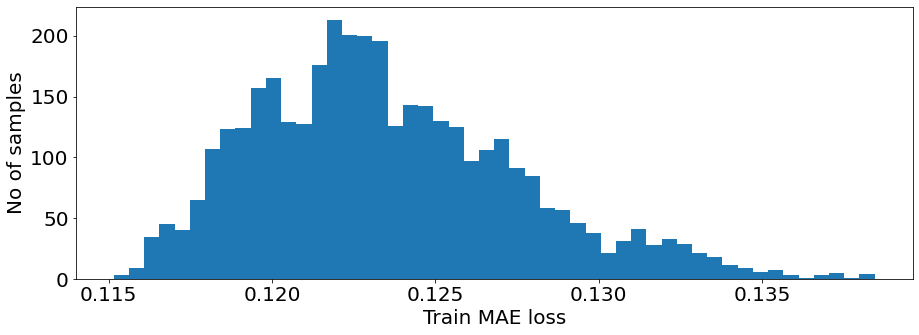

Reconstruction error threshold:  0.1384491121149436


In [29]:
# Get train MAE loss.
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


# Testing the methodlogy
<hr style="border:2px solid black"> </hr>


- We'll prepare the test data in the same way we prepared the training data.
- This will the be fed to the model which will try to reconstruct them all.
- We'll get the MAE loss and we'll make our conclusion based on this.



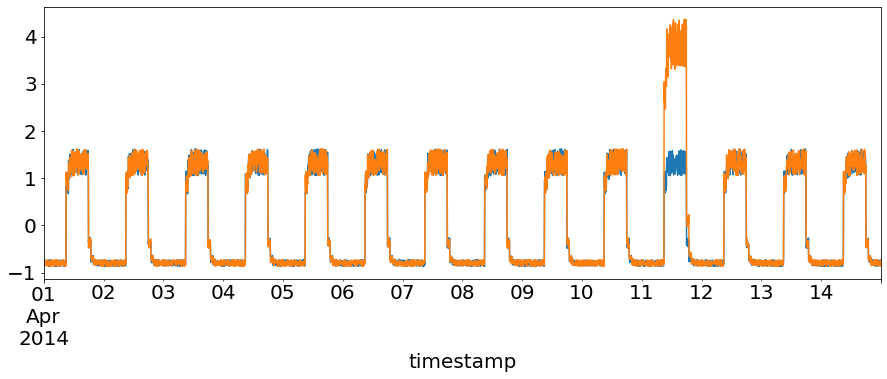

In [42]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
# training
df_training_value.plot(legend=False, ax=ax)
# test
df_test_value.plot(legend=False, ax=ax)
plt.show()

In [43]:
# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


In [44]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

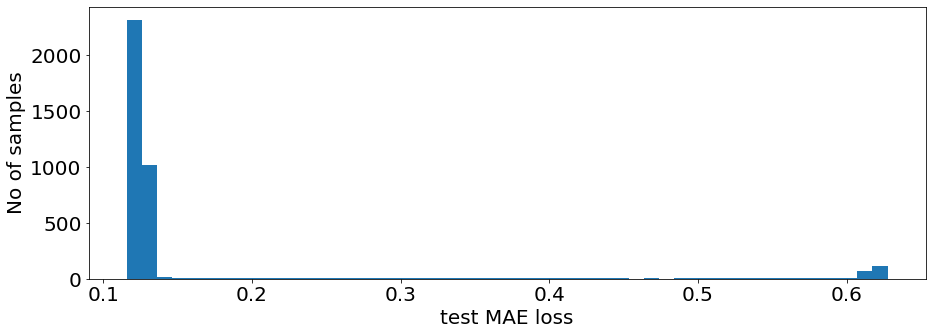

In [45]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [46]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  403
Indices of anomaly samples:  (array([ 212, 1652, 1653, 1659, 1833, 2696, 2697, 2701, 2702, 2703, 2704,
       2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715,
       2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726,
       2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737,
       2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748,
       2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
       2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770,
       2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781,
       2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792,
       2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803,
       2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814,
       2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825,
       2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2

# Plotting the anomlies
<hr style="border:2px solid black"> </hr>


- We now know the samples of the data which are anomalies. With this, we will find the corresponding timestamps from the original test data. We will be using the following method to do that:
- Let's say time_steps = 3 and we have 10 training values. Our x_train will look like this:

    `0, 1, 2`
    `1, 2, 3`
    `2, 3, 4`
    `3, 4, 5`
    `4, 5, 6`
    `5, 6, 7`
    `6, 7, 8`
    `7, 8, 9`

- All except the initial and the final time_steps-1 data values, will appear in time_steps number of samples. So, if we know that the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point 5 is an anomaly.



In [48]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)


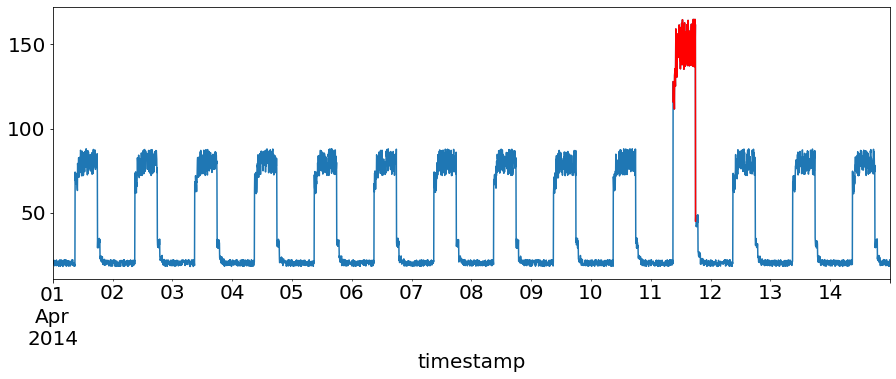

In [49]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()


# References
<hr style="border:2px solid black"> </hr>


- https://keras.io/examples/timeseries/timeseries_anomaly_detection/
- [Dataset](https://www.kaggle.com/boltzmannbrain/nab)
- [Keras early_stopping mode](https://keras.io/api/callbacks/early_stopping/)

